<a href="https://colab.research.google.com/github/HST0077/HYOTC/blob/main/StepDown_3stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3 Stock Step Down 상품 평가하기

In [2]:
# 주말 제외한 6개월마다의 날짜 생성
import pandas as pd

D0=pd.date_range('2026-01-02',periods=6,freq=pd.DateOffset(months=6))
D0

DatetimeIndex(['2026-01-02', '2026-07-02', '2027-01-02', '2027-07-02',
               '2028-01-02', '2028-07-02'],
              dtype='datetime64[ns]', freq='<DateOffset: months=6>')

In [3]:
# 대한민국의 달력기준으로 데이터 만들기
import holidays # 별도로 설치하여야 함

# 주말을 제외한 대한민국의 휴일 정보를 가져온다.
kor_holidays=list(holidays.KOR(years=range(2025,2029)).keys()) #list()데이터로 변환
kor_holidays=pd.to_datetime(kor_holidays) # 데이터프레임 날짜로 변환

# Business days로 6개의 날짜 생성
D_samples=pd.date_range('2026-01-02',periods=6,freq=pd.DateOffset(months=6))

# 생성된 날짜에서 대한민국 휴일 제외
# 아래에서 사용된 isin()은 존재하는지를 확인하는 내장함수
D0=D_samples[~D_samples.isin(kor_holidays)] # 휴일정보에 포함되지 않는 날짜만 추출
D0

DatetimeIndex(['2026-01-02', '2026-07-02', '2027-01-02', '2027-07-02',
               '2028-01-02', '2028-07-02'],
              dtype='datetime64[ns]', freq='<DateOffset: months=6>')

In [4]:
import pandas as pd
import holidays
from datetime import datetime

# 대한민국 공휴일 불러오기
kor_holidays = list(holidays.KOR(years=range(2026, 2031)).keys())
kor_holidays = pd.to_datetime(kor_holidays)

# 오늘 날짜
today = pd.to_datetime(datetime.today().date())
six_months_later = today + pd.DateOffset(months=6)

# 6개월마다의 기준일 생성
month_starts = pd.date_range(start=six_months_later, periods=6, freq=pd.DateOffset(months=6))

# 각 기준일에서 해당 월의 첫 번째 영업일(공휴일 제외) 추출
business_days = []
for dt in month_starts:
    # 시작 날짜부터 한 달간의 영업일 추출
    month_range = pd.date_range(start=dt, end=dt + pd.offsets.MonthEnd(0), freq='B')
    # 영업일이 대한민국의 휴일이 아닌 것을 다시 추출출
    valid_days = [d for d in month_range if d not in kor_holidays]
    if valid_days: # 자료가 있다면
        business_days.append(valid_days[0])

# 결과 출력
print(business_days)


[Timestamp('2026-07-06 00:00:00'), Timestamp('2027-01-04 00:00:00'), Timestamp('2027-07-05 00:00:00'), Timestamp('2028-01-04 00:00:00'), Timestamp('2028-07-04 00:00:00'), Timestamp('2029-01-04 00:00:00')]


In [5]:
from datetime import datetime

# 날짜 차이 계산 (단위: 일수)
days_diff = [(d - today).days for d in business_days]

# DataFrame 생성
df = pd.DataFrame({
    '영업일': [d.strftime('%Y-%m-%d') for d in business_days],
    '오늘까지 남은 일수': days_diff})
df

,영업일,오늘까지 남은 일수
0,2026-07-06,183
1,2027-01-04,365
2,2027-07-05,547
3,2028-01-04,730
4,2028-07-04,912
5,2029-01-04,1096


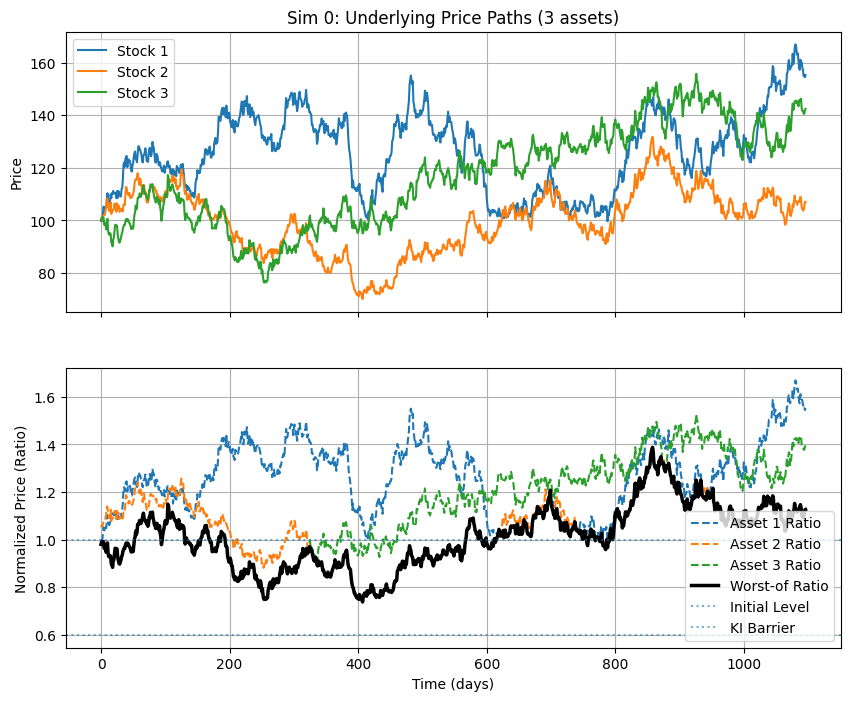

In [6]:
# 시뮬레이션 횟수 만큼 주가 3개 생성하기
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# 주가 경로 생성
N = df['오늘까지 남은 일수'].iloc[-1]  # 만기까지의 날짜수
sim = 1000
r = 0.05
sigma1, sigma2, sigma3 = 0.30, 0.30, 0.30
dt = 1 / 365

np.random.seed(111)

# 기초자산 초기 가격
S0_1, S0_2, S0_3 = 100.0, 100.0, 100.0

# 기준가격(정규화용)
kijun_price_1, kijun_price_2, kijun_price_3 = 100.0, 95.0, 102.0

# ======================================================
# 1) 상관 표준정규 난수 생성 (3자산)
#    예시: (1,2)=0.6, (1,3)=0.4, (2,3)=0.5
# ======================================================
rho12, rho13, rho23 = 0.6, 0.4, 0.5

cov = np.array([
    [1.0,  rho12, rho13],
    [rho12, 1.0,  rho23],
    [rho13, rho23, 1.0]
])

W = multivariate_normal.rvs(
    mean=[0.0, 0.0, 0.0],
    cov=cov,
    size=(N, sim)
)  # (N, sim, 3)

W1 = W[:, :, 0]
W2 = W[:, :, 1]
W3 = W[:, :, 2]

# ======================================================
# 2) GBM log-price increments (3자산)
# ======================================================
drift1 = (r - 0.5 * sigma1**2) * dt
drift2 = (r - 0.5 * sigma2**2) * dt
drift3 = (r - 0.5 * sigma3**2) * dt

vol1 = sigma1 * np.sqrt(dt)
vol2 = sigma2 * np.sqrt(dt)
vol3 = sigma3 * np.sqrt(dt)

lnS1 = drift1 + vol1 * W1
lnS2 = drift2 + vol2 * W2
lnS3 = drift3 + vol3 * W3

# t=0 포함
lnS1 = np.insert(lnS1, 0, np.log(S0_1), axis=0)
lnS2 = np.insert(lnS2, 0, np.log(S0_2), axis=0)
lnS3 = np.insert(lnS3, 0, np.log(S0_3), axis=0)

S1 = np.exp(np.cumsum(lnS1, axis=0))  # (N+1, sim)
S2 = np.exp(np.cumsum(lnS2, axis=0))  # (N+1, sim)
S3 = np.exp(np.cumsum(lnS3, axis=0))  # (N+1, sim)

# ======================================================
# 3) 기준가격으로 정규화 → worst-of (3자산)
# ======================================================
ratio1 = S1 / kijun_price_1
ratio2 = S2 / kijun_price_2
ratio3 = S3 / kijun_price_3

# worst-of (비율 기준)
worst_of = np.minimum(np.minimum(ratio1, ratio2), ratio3)  # (N+1, sim)

# ======================================================
# 4) 2번째 sim의 path 보기
# ======================================================
i = 1

S1_path = S1[:, i]
S2_path = S2[:, i]
S3_path = S3[:, i]

ratio1_path = ratio1[:, i]
ratio2_path = ratio2[:, i]
ratio3_path = ratio3[:, i]
worst_path  = worst_of[:, i]

time = np.arange(len(S1_path))  # 0 ~ N

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 가격 경로
axes[0].plot(time, S1_path, label='Stock 1')
axes[0].plot(time, S2_path, label='Stock 2')
axes[0].plot(time, S3_path, label='Stock 3')
axes[0].set_ylabel('Price')
axes[0].set_title('Sim 0: Underlying Price Paths (3 assets)')
axes[0].legend()
axes[0].grid(True)

# ===== worst-of subplot =====
axes[1].plot(time, ratio1_path, linestyle='--', linewidth=1.5, label='Asset 1 Ratio')
axes[1].plot(time, ratio2_path, linestyle='--', linewidth=1.5, label='Asset 2 Ratio')
axes[1].plot(time, ratio3_path, linestyle='--', linewidth=1.5, label='Asset 3 Ratio')

axes[1].plot(time, worst_path, color='black', linewidth=2.5, label='Worst-of Ratio')

# 기준선
axes[1].axhline(1.0, linestyle=':', alpha=0.6, label='Initial Level')
axes[1].axhline(0.6, linestyle=':', alpha=0.6, label='KI Barrier')

axes[1].set_ylabel('Normalized Price (Ratio)')
axes[1].set_xlabel('Time (days)')
axes[1].legend()
axes[1].grid(True)

plt.show()



In [7]:
def SD_3star_GPU_CRN(
    S, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
    sim, seed=111, antithetic=True,
    Z=None, return_Z=False,
    notional=10000.0, dtype="float64"
):
    """
    3자산(worst-of) StepDown ELS GPU pricer with CRN support

    Parameters
    - S      : (3,) 초기 주가 [S0_1, S0_2, S0_3]
    - kijun  : (3,) 기준가격 [k1, k2, k3]
    - K      : (EN,) 관측일 기준 (ratio 기준)
    - T      : (EN,) 관측일(일 단위, 정수). 마지막 원소가 만기일.
    - c      : (EN,) 회차 쿠폰
    - r      : 무위험이자율(연)
    - q      : (3,) 배당률
    - sigma  : (3,) 변동성
    - Corr   : (3,3) 상관행렬 (대각 1, PSD)
    - barrier: KI 배리어 (ratio 기준)
    - dummy  : KI 미발생 시 만기 쿠폰(또는 지급률)
    - sim    : 시뮬레이션 개수
    - seed   : 난수 seed
    - antithetic: 대칭변수 사용 여부
    - Z      : (N, sim, 3) 표준정규 난수 (CRN용). None이면 내부 생성
    - return_Z: True면 (mu, Z) 반환
    - notional: 원금
    - dtype  : "float64" or "float32"

    Returns
    - mu 또는 (mu, Z)
    """

    import cupy as cp
    import numpy as np

    # ---------- 입력 정리 ----------
    S_np = np.asarray(S, dtype=float).reshape(3,)
    kijun_np = np.asarray(kijun, dtype=float).reshape(3,)
    sigma_np = np.asarray(sigma, dtype=float).reshape(3,)
    q_np = np.asarray(q, dtype=float).reshape(3,)

    T_np = np.atleast_1d(np.asarray(T, dtype=int))
    K_np = np.atleast_1d(np.asarray(K, dtype=float))
    c_np = np.atleast_1d(np.asarray(c, dtype=float))

    EN = len(T_np)
    if not (len(K_np) == EN and len(c_np) == EN):
        raise ValueError("K, T, c의 길이는 같아야 합니다. (EN회차)")

    Corr_np = np.asarray(Corr, dtype=float).reshape(3, 3)

    # dtype
    dtype_cp = cp.float64 if dtype == "float64" else cp.float32

    # ---------- GPU로 올리기 ----------
    S_cp = cp.asarray(S_np, dtype=dtype_cp)
    kijun_cp = cp.asarray(kijun_np, dtype=dtype_cp)
    sigma_cp = cp.asarray(sigma_np, dtype=dtype_cp)
    q_cp = cp.asarray(q_np, dtype=dtype_cp)

    K_cp = cp.asarray(K_np, dtype=dtype_cp)
    c_cp = cp.asarray(c_np, dtype=dtype_cp)

    Corr_cp = cp.asarray(Corr_np, dtype=dtype_cp)

    dt = dtype_cp(1.0 / 365.0)

    # ---------- Z 준비 (CRN) ----------
    if Z is None:
        N = int(T_np[-1])
        if N <= 0:
            raise ValueError("T[-1] (만기일)은 양의 정수(일)여야 합니다.")

        cp.random.seed(seed)

        if antithetic:
            half = (sim + 1) // 2
            Z_half = cp.random.standard_normal((N, half, 3), dtype=dtype_cp)
            Z = cp.concatenate([Z_half, -Z_half], axis=1)[:, :sim, :]
        else:
            Z = cp.random.standard_normal((N, sim, 3), dtype=dtype_cp)
    else:
        if not hasattr(Z, "shape") or len(Z.shape) != 3 or Z.shape[2] != 3:
            raise ValueError("Z는 (N, sim, 3) 형태여야 합니다.")
        N, sim_Z, _ = Z.shape
        sim = int(sim_Z)

        if int(T_np[-1]) > N:
            raise ValueError(f"T[-1]={int(T_np[-1])}가 Z의 N={N}보다 큽니다. Z를 더 길게 생성하세요.")

        Z = Z.astype(dtype_cp, copy=False)

    # ---------- 상관 부여: W = Z @ L.T ----------
    # Corr이 PSD가 아니면 chol이 실패할 수 있음 (필요 시 nearest-PSD 처리)
    L = cp.linalg.cholesky(Corr_cp)
    W = Z @ L.T                          # (N, sim, 3)
    W1, W2, W3 = W[:, :, 0], W[:, :, 1], W[:, :, 2]

    # ---------- GBM 경로 ----------
    drift = (r - q_cp - 0.5 * sigma_cp**2) * dt     # (3,)
    vol   = sigma_cp * cp.sqrt(dt)                  # (3,)

    lnS1 = drift[0] + vol[0] * W1
    lnS2 = drift[1] + vol[1] * W2
    lnS3 = drift[2] + vol[2] * W3

    lnS1 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[0]), dtype=dtype_cp), lnS1], axis=0)
    lnS2 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[1]), dtype=dtype_cp), lnS2], axis=0)
    lnS3 = cp.concatenate([cp.full((1, sim), cp.log(S_cp[2]), dtype=dtype_cp), lnS3], axis=0)

    S1 = cp.exp(cp.cumsum(lnS1, axis=0))  # (N+1, sim)
    S2 = cp.exp(cp.cumsum(lnS2, axis=0))
    S3 = cp.exp(cp.cumsum(lnS3, axis=0))

    # ---------- worst-of ratio ----------
    ratio1 = S1 / kijun_cp[0]
    ratio2 = S2 / kijun_cp[1]
    ratio3 = S3 / kijun_cp[2]
    R = cp.minimum(cp.minimum(ratio1, ratio2), ratio3)  # (N+1, sim)

    # ---------- 조기상환 ----------
    Price = cp.zeros(sim, dtype=dtype_cp)

    for i in range(EN - 1):
        t = int(T_np[i])
        alive = (Price == 0.0)
        hit = alive & (R[t, :] >= K_cp[i])
        Price = cp.where(
            hit,
            dtype_cp(notional) * (dtype_cp(1.0) + c_cp[i]) * cp.exp(-r * t / 365.0),
            Price
        )

    # ---------- 만기상환 ----------
    alive = (Price == 0.0)
    if cp.any(alive):
        R_alive = R[:, alive]  # (N+1, n_alive)
        ki_hit = (cp.min(R_alive, axis=0) < barrier)

        t_mat = int(T_np[-1])

        payoff_ki = dtype_cp(notional) * R_alive[t_mat, :] * cp.exp(-r * t_mat / 365.0)
        payoff_no = dtype_cp(notional) * (dtype_cp(1.0) + dtype_cp(dummy)) * cp.exp(-r * t_mat / 365.0)

        Price_alive = cp.where(ki_hit, payoff_ki, payoff_no)
        Price[alive] = Price_alive

    mu = float(cp.mean(Price).get())
    if return_Z:
        return mu, Z
    return mu


In [8]:
# 스텝다운 상품 평가 정보 (3-stock 예시)
S0 = [100, 100, 100]
kijun = [100, 95, 101]          # 예시로 2번째만 95로 둠
r = 0.035
q = [0,0,0]
sigma = [0.3, 0.5, 0.4]
rho = 0.6

barrier = 0.65
dummy = 0.132
sim = 10000

K = [0.95, 0.95, 0.95, 0.90, 0.90, 0.85]

# ✅ 관측일은 K 길이(=6)와 같아야 함: 예시로 df에서 6개 뽑는 형태
# (실제론 상품 관측일에 맞춰 넣어야 함)
T = np.array(df['오늘까지 남은 일수'].iloc[:6], dtype=int)

c = np.array([1, 2, 3, 4, 5, 6]) * 0.022


Corr3 = np.array([
    [1.0, 0.6, 0.4],
    [0.6, 1.0, 0.5],
    [0.4, 0.5, 1.0]
])

SD_3star_GPU_CRN(
    S=[100,100,100],
    kijun=[100,95,102],
    K=K, T=T, c=c,
    r=r, q=[0,0,0],
    sigma=[0.3,0.3,0.3],
    Corr=Corr3,
    barrier=0.65, dummy=0.132,
    sim=20000,
    seed=111, antithetic=True,
    Z=None, return_Z=True
)



(8042.340606615934,
 array([[[ 0.27893988,  0.04719979,  1.68399562],
         [ 2.68323992, -0.14224667, -2.0266374 ],
         [ 0.86251745, -0.44509835,  0.8315874 ],
         ...,
         [-0.39870996, -1.50356042, -0.48049126],
         [ 0.02189215, -1.27757127,  1.20028649],
         [ 1.51483708,  0.87310587,  1.74135333]],
 
        [[ 0.00935225, -0.98410248,  1.27269506],
         [ 1.03893775,  0.31955436,  1.47285603],
         [-0.08767244,  0.81486037, -0.89433688],
         ...,
         [ 0.85726185,  0.76075436, -1.02585929],
         [-0.99346045, -1.44602196,  1.02714986],
         [ 1.53074776,  1.01281068,  0.75794213]],
 
        [[-0.79411205,  0.22301175,  0.33639725],
         [-0.13028061, -0.38486197,  1.28487138],
         [ 0.85497961, -0.69787743, -0.20389205],
         ...,
         [-0.8665566 ,  0.01393345,  1.21517866],
         [ 1.53245276, -0.93617509, -0.19196101],
         [ 0.52834332,  0.79252243,  0.85581101]],
 
        ...,
 
        [[ 0.0

In [15]:
# GPU 메모리 감소 버전

def SD_3star_GPU_CRN_stream(
    S, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
    sim, seed=111, antithetic=True,
    notional=10000.0, dtype="float64",
    chunk_size=20000,
):
    import cupy as cp
    import numpy as np

    # ---------- 입력 정리 ----------
    S_np = np.asarray(S, dtype=float).reshape(3,)
    kijun_np = np.asarray(kijun, dtype=float).reshape(3,)
    sigma_np = np.asarray(sigma, dtype=float).reshape(3,)
    q_np = np.asarray(q, dtype=float).reshape(3,)

    T_np = np.atleast_1d(np.asarray(T, dtype=int))
    K_np = np.atleast_1d(np.asarray(K, dtype=float))
    c_np = np.atleast_1d(np.asarray(c, dtype=float))

    EN = len(T_np)
    if not (len(K_np) == EN and len(c_np) == EN):
        raise ValueError("K, T, c의 길이는 같아야 합니다. (EN회차)")

    N = int(T_np[-1])
    if N <= 0:
        raise ValueError("T[-1] (만기일)은 양의 정수(일)여야 합니다.")

    Corr_np = np.asarray(Corr, dtype=float).reshape(3, 3)

    dtype_cp = cp.float64 if dtype == "float64" else cp.float32

    # ---------- GPU 상수 ----------
    S0 = cp.asarray(S_np, dtype=dtype_cp)
    kij = cp.asarray(kijun_np, dtype=dtype_cp)
    sig = cp.asarray(sigma_np, dtype=dtype_cp)
    qq  = cp.asarray(q_np, dtype=dtype_cp)

    Kcp = cp.asarray(K_np, dtype=dtype_cp)
    ccp = cp.asarray(c_np, dtype=dtype_cp)

    Corr_cp = cp.asarray(Corr_np, dtype=dtype_cp)
    L = cp.linalg.cholesky(Corr_cp)

    dt = dtype_cp(1.0 / 365.0)
    sqdt = cp.sqrt(dt)

    drift = (r - qq - 0.5 * sig**2) * dt   # (3,)
    vol   = sig * sqdt                     # (3,)

    # 조기상환 관측(만기 제외)
    obs_T_np = T_np[:-1]
    obs_K_cp = cp.asarray(K_np[:-1], dtype=dtype_cp)
    obs_c_cp = cp.asarray(c_np[:-1], dtype=dtype_cp)
    n_obs = len(obs_T_np)

    # obs_T는 인덱싱에 쓰기 좋게 GPU int로도 준비
    obs_T_cp = cp.asarray(obs_T_np.astype(np.int32), dtype=cp.int32)

    rng = cp.random.RandomState(seed)

    total_sum = 0.0
    total_cnt = 0

    for start in range(0, sim, chunk_size):
        m = min(chunk_size, sim - start)

        half = (m + 1) // 2 if antithetic else m

        # logS (m,3)
        logS = cp.tile(cp.log(S0)[None, :], (m, 1))
        min_worst = cp.full((m,), cp.inf, dtype=dtype_cp)

        # 관측일 worst 저장 (n_obs, m)
        if n_obs > 0:
            worst_obs = cp.empty((n_obs, m), dtype=dtype_cp)
        obs_idx = 0

        for t in range(1, N + 1):
            Z_half = rng.standard_normal((half, 3), dtype=dtype_cp)
            Z_t = cp.concatenate([Z_half, -Z_half], axis=0)[:m, :] if antithetic else Z_half

            W_t = Z_t @ L.T
            logS = logS + drift[None, :] + vol[None, :] * W_t

            ratio = cp.exp(logS) / kij[None, :]
            worst = cp.min(ratio, axis=1)
            min_worst = cp.minimum(min_worst, worst)

            if n_obs > 0 and obs_idx < n_obs and t == int(obs_T_np[obs_idx]):
                worst_obs[obs_idx, :] = worst
                obs_idx += 1

        # ---------- 조기상환 판정 (여기가 핵심 수정) ----------
        Price = cp.zeros((m,), dtype=dtype_cp)

        if n_obs > 0:
            hit = (worst_obs >= obs_K_cp[:, None])     # (n_obs, m)
            any_hit = cp.any(hit, axis=0)              # (m,)

            # any_hit=False인 경로도 argmax는 0을 주지만, any_hit로 걸러서 사용하면 OK
            first_idx = cp.argmax(hit, axis=0).astype(cp.int32)  # (m,)

            # (m,)짜리로 "전체" t_hit, c_hit을 만든 뒤,
            # any_hit인 위치만 의미 있게 사용
            t_hit_all = obs_T_cp[first_idx]            # (m,)
            c_hit_all = obs_c_cp[first_idx]            # (m,)

            pv_all = dtype_cp(notional) * (dtype_cp(1.0) + c_hit_all) * cp.exp(-r * t_hit_all / 365.0)  # (m,)

            Price = cp.where(any_hit, pv_all, Price)   # ✅ (m,),(m,),(m,)로 shape 일치

        # ---------- 만기상환 ----------
        alive = (Price == 0.0)
        if cp.any(alive):
            ratio_T = cp.exp(logS[alive, :]) / kij[None, :]
            worst_T = cp.min(ratio_T, axis=1)

            ki_hit = (min_worst[alive] < barrier)

            t_mat = int(T_np[-1])
            pv_ki = dtype_cp(notional) * worst_T * cp.exp(-r * t_mat / 365.0)
            pv_no = dtype_cp(notional) * (dtype_cp(1.0) + dtype_cp(dummy)) * cp.exp(-r * t_mat / 365.0)

            Price_alive = cp.where(ki_hit, pv_ki, pv_no)
            Price[alive] = Price_alive

        total_sum += float(cp.sum(Price).get())
        total_cnt += m

        cp.get_default_memory_pool().free_all_blocks()

    return total_sum / total_cnt


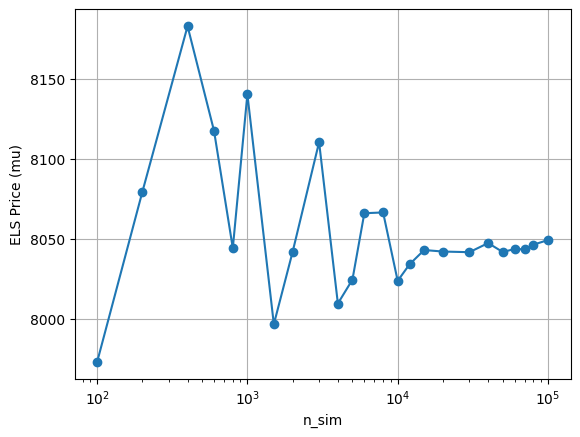

In [17]:
S0 = [100, 100, 100]
kijun = [100, 95, 102]
q = [0, 0, 0]
sigma = [0.3, 0.3, 0.3]

Corr3 = np.array([
    [1.0, 0.6, 0.4],
    [0.6, 1.0, 0.5],
    [0.4, 0.5, 1.0]
])

Sims=[100,200,400,600,800,1000,1500,2000,3000,4000,
      5000,6000,8000,10000,12000,15000,20000,30000,
      40000,50000,60000,70000,80000,100000]

Price_Sims = []

for sim_ in Sims:
    mu = SD_3star_GPU_CRN_stream(
        S0, kijun, K, T, c, r, q, sigma, Corr3, barrier, dummy,
        sim=sim_, seed=111, antithetic=True,
        chunk_size=20000
    )
    Price_Sims.append(mu)

plt.figure()
plt.plot(Sims, Price_Sims, marker='o')
plt.xscale('log')  # 로그스케일로 보면 수렴이 잘 보임
plt.xlabel("n_sim")
plt.ylabel("ELS Price (mu)")
plt.grid(True)
plt.show()


In [9]:
import numpy as np

def MC_Greeks_SD3_GPU_CRN(
    pricer,   # SD_3star_GPU_CRN (Z를 반환/재사용 가능해야 함)
    S0, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
    sim, seed=111, antithetic=True,
    notional=10000.0, dtype="float64",
    bump_S_frac=0.01,       # eps_S[i] = S0[i]*sigma[i]*bump_S_frac
    bump_sigma_frac=0.01,   # eps_sigma[i] = sigma[i]*bump_sigma_frac
    bump_r_bp=1             # r bump: 1bp
):
    """
    3자산(worst-of) StepDown ELS의 CRN Greeks (GPU)

    요구사항(pricer):
    - pricer(..., Z=None, return_Z=True) -> (price, Z)
    - pricer(..., Z=Z, return_Z=False) -> price
    - Z shape: (N, sim, 3)  (N = T[-1])
    """

    # ---- 입력 정리 ----
    S0 = np.asarray(S0, dtype=float).reshape(3,)
    kijun = np.asarray(kijun, dtype=float).reshape(3,)

    q = np.asarray(q, dtype=float).reshape(3,)
    sigma = np.asarray(sigma, dtype=float).reshape(3,)

    Corr = np.asarray(Corr, dtype=float).reshape(3, 3)

    T = np.atleast_1d(np.asarray(T, dtype=int))
    K = np.atleast_1d(np.asarray(K, dtype=float))
    c = np.atleast_1d(np.asarray(c, dtype=float))

    if not (len(T) == len(K) == len(c)):
        raise ValueError("K, T, c 길이는 같아야 합니다.")

    # ---- 0) CRN용 Z 1회 생성 + base price ----
    C0, Z = pricer(
        S0, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
        sim=sim, seed=seed, antithetic=antithetic,
        Z=None, return_Z=True, notional=notional, dtype=dtype
    )

    # ======================================================
    # 1) Delta / Gamma (각 자산별)
    # ======================================================
    Delta = np.zeros(3, dtype=float)
    Gamma = np.zeros(3, dtype=float)

    eps_S = np.maximum(S0 * sigma * bump_S_frac, 1e-12)

    for j in range(3):
        S_up = S0.copy(); S_up[j] += eps_S[j]
        S_dn = S0.copy(); S_dn[j] -= eps_S[j]

        Cp = pricer(
            S_up, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )
        Cm = pricer(
            S_dn, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )

        Delta[j] = (Cp - Cm) / (2.0 * eps_S[j])
        Gamma[j] = (Cp - 2.0 * C0 + Cm) / (eps_S[j] ** 2)

    # ======================================================
    # 1-b) Cross-Gamma (pairwise): d2C/dSi dSj
    #      3자산이면 (0,1), (0,2), (1,2) 3개가 자연스러움
    # ======================================================
    pairs = [(0, 1), (0, 2), (1, 2)]
    CrossGamma = {}

    for (i, j) in pairs:
        ei = eps_S[i]
        ej = eps_S[j]

        S_pp = S0.copy(); S_pp[i] += ei; S_pp[j] += ej
        S_pm = S0.copy(); S_pm[i] += ei; S_pm[j] -= ej
        S_mp = S0.copy(); S_mp[i] -= ei; S_mp[j] += ej
        S_mm = S0.copy(); S_mm[i] -= ei; S_mm[j] -= ej

        C_pp = pricer(S_pp, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
                      sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
        C_pm = pricer(S_pm, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
                      sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
        C_mp = pricer(S_mp, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
                      sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)
        C_mm = pricer(S_mm, kijun, K, T, c, r, q, sigma, Corr, barrier, dummy,
                      sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype)

        CrossGamma[(i, j)] = (C_pp - C_pm - C_mp + C_mm) / (4.0 * ei * ej)

    # ======================================================
    # 2) Vega (각 자산별, 1% Vega)
    # ======================================================
    Vega = np.zeros(3, dtype=float)
    Vega_1pct = np.zeros(3, dtype=float)

    eps_sig = np.maximum(sigma * bump_sigma_frac, 1e-12)

    for j in range(3):
        sig_up = sigma.copy(); sig_up[j] += eps_sig[j]
        sig_dn = sigma.copy(); sig_dn[j] -= eps_sig[j]

        Csig_p = pricer(
            S0, kijun, K, T, c, r, q, sig_up, Corr, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )
        Csig_m = pricer(
            S0, kijun, K, T, c, r, q, sig_dn, Corr, barrier, dummy,
            sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
        )

        Vega[j] = (Csig_p - Csig_m) / (2.0 * eps_sig[j])
        Vega_1pct[j] = 0.01 * Vega[j]

    # ======================================================
    # 3) Theta (1-day): 모든 관측일 1일 당김
    #    주의: T 전체를 -1하면 관측일 간격이 유지된 "하루 전" 구조가 됨
    # ======================================================
    Tm = np.maximum(T - 1, 0)

    Ct = pricer(
        S0, kijun, K, Tm, c, r, q, sigma, Corr, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )
    Theta_1d = Ct - C0

    # ======================================================
    # 4) Rho (1bp)
    # ======================================================
    eps_r = bump_r_bp * 0.0001

    Cr_p = pricer(
        S0, kijun, K, T, c, r + eps_r, q, sigma, Corr, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )
    Cr_m = pricer(
        S0, kijun, K, T, c, r - eps_r, q, sigma, Corr, barrier, dummy,
        sim=sim, Z=Z, return_Z=False, notional=notional, dtype=dtype
    )

    Rho_per_unit = (Cr_p - Cr_m) / (2.0 * eps_r)
    Rho_1bp = 0.0001 * Rho_per_unit

    return {
        "Price": C0,
        "Delta": Delta,                 # (3,)
        "Gamma": Gamma,                 # (3,)
        "CrossGamma": CrossGamma,       # dict: {(0,1):..., (0,2):..., (1,2):...}
        "Vega(1%)": Vega_1pct,          # (3,)
        "Theta(1d)": Theta_1d,
        "Rho(1bp)": Rho_1bp,
        "bump": {
            "eps_S": eps_S.tolist(),
            "eps_sigma": eps_sig.tolist(),
            "eps_r": eps_r,
            "CRN": True,
            "antithetic": antithetic,
            "seed": seed,
        }
    }


In [12]:
MC_Greeks_SD3_GPU_CRN(
    pricer=SD_3star_GPU_CRN,
    S0=[100,100,100],
    kijun=[100,95,102],
    K=K, T=T, c=c,
    r=r, q=[0,0,0],
    sigma=[0.3,0.3,0.3],
    Corr=Corr3,
    barrier=0.65, dummy=0.132,
    sim=30000,
    seed=111, antithetic=True,
)

{'Price': 8045.379737174602,
 'Delta': array([30.59033289, 19.8502214 , 35.77480129]),
 'Gamma': array([-11.54928797, -16.50450409,  -2.28692244]),
 'CrossGamma': {(0, 1): np.float64(-0.18142811009561735),
  (0, 2): np.float64(-0.06612089499008612),
  (1, 2): np.float64(1.103544709563822)},
 'Vega(1%)': array([-31.8189333 , -25.40426534, -30.09703161]),
 'Theta(1d)': -1.0983435199905216,
 'Rho(1bp)': -0.17347467750369105,
 'bump': {'eps_S': [0.3, 0.3, 0.3],
  'eps_sigma': [0.003, 0.003, 0.003],
  'eps_r': 0.0001,
  'CRN': True,
  'antithetic': True,
  'seed': 111}}

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_convexity_SD3(
    pricer,                 # SD_3star_GPU_CRN
    S0, kijun, K, T, c,
    r, q, sigma, Corr,
    barrier, dummy,
    asset_idx=0,            # 0,1,2 중 하나
    sim=30000,
    seed=111,
    antithetic=True,
    width=0.05,             # S0*(1±width)
    n_grid=21,
    notional=10000.0,
    dtype="float64",
    use_crn=True
):
    """
    SD_3star_GPU_CRN 기반 Convexity (Price vs S) 그래프

    asset_idx : 어느 자산을 움직일지 (0/1/2)
    width     : S0 기준 ±비율
    n_grid    : S grid 개수
    use_crn   : True면 동일 Z 재사용 (권장)
    """

    # ---- 입력 정리 ----
    S0 = np.asarray(S0, float).reshape(3,)
    kijun = np.asarray(kijun, float).reshape(3,)
    q = np.asarray(q, float).reshape(3,)
    sigma = np.asarray(sigma, float).reshape(3,)
    Corr = np.asarray(Corr, float).reshape(3, 3)

    T = np.atleast_1d(np.asarray(T, int))
    K = np.atleast_1d(np.asarray(K, float))
    c = np.atleast_1d(np.asarray(c, float))

    # ---- S grid ----
    S_center = S0[asset_idx]
    S_grid = np.linspace(
        S_center * (1 - width),
        S_center * (1 + width),
        n_grid
    )

    # ---- Base price + CRN Z ----
    if use_crn:
        C0, Z = pricer(
            S0, kijun, K, T, c,
            r, q, sigma, Corr,
            barrier, dummy,
            sim=sim, seed=seed, antithetic=antithetic,
            Z=None, return_Z=True,
            notional=notional, dtype=dtype
        )
    else:
        Z = None
        C0 = pricer(
            S0, kijun, K, T, c,
            r, q, sigma, Corr,
            barrier, dummy,
            sim=sim, seed=seed, antithetic=antithetic,
            Z=None, return_Z=False,
            notional=notional, dtype=dtype
        )

    # ---- Price curve ----
    prices = []

    for s in S_grid:
        S_tmp = S0.copy()
        S_tmp[asset_idx] = s

        if use_crn:
            p = pricer(
                S_tmp, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim,
                Z=Z, return_Z=False,
                notional=notional, dtype=dtype
            )
        else:
            p = pricer(
                S_tmp, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, seed=seed, antithetic=antithetic,
                Z=None, return_Z=False,
                notional=notional, dtype=dtype
            )

        prices.append(p)

    prices = np.array(prices)

    # ---- Plot ----
    plt.figure(figsize=(8, 5))
    plt.plot(S_grid, prices, marker="o", linewidth=2)
    plt.axvline(S_center, linestyle="--", alpha=0.6, label="S0")
    plt.title(
        f"Convexity Check (Asset {asset_idx})\n"
        f"CRN={use_crn}, sim={sim}"
    )
    plt.xlabel(f"S[{asset_idx}]")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.show()

    return {
        "S_grid": S_grid,
        "prices": prices,
        "center_price": C0
    }


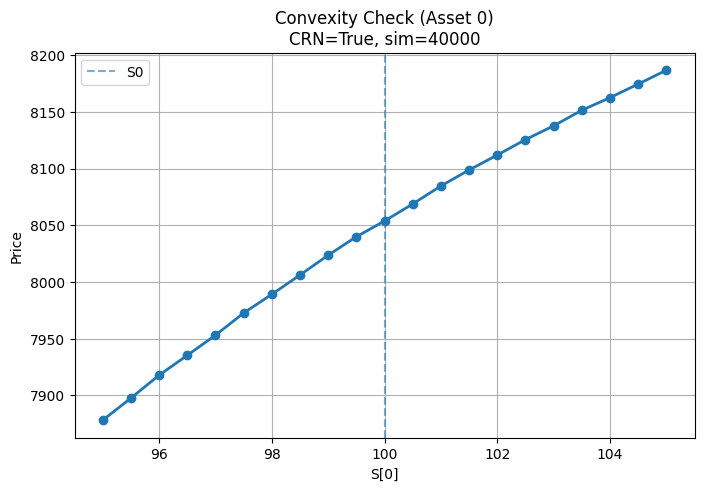

In [24]:
out = plot_convexity_SD3(
    pricer=SD_3star_GPU_CRN,
    S0=S0,
    kijun=kijun,
    K=K,
    T=T,
    c=c,
    r=r,
    q=q,
    sigma=sigma,
    Corr=Corr3,
    barrier=barrier,
    dummy=dummy,
    asset_idx=0,        # 자산 0의 Convexity
    sim=40000,
    width=0.05,
    n_grid=21,
    use_crn=True        # ⭐ 중요
)


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def delta_vs_S_SD3(
    pricer,                 # SD_3star_GPU_CRN
    S0, kijun, K, T, c,
    r, q, sigma, Corr,
    barrier, dummy,
    asset_idx=0,            # delta 볼 자산 index (0/1/2)
    sim=40000,
    seed=111,
    antithetic=True,
    width=0.05,             # S0*(1±width)
    n_grid=21,
    bump_S_frac=0.01,       # eps_S = S*sigma*bump_S_frac (각 grid의 S 기준)
    notional=10000.0,
    dtype="float64",
    use_crn=True
):
    """
    S_grid에서 Price(S)와 Delta(S)를 CRN으로 계산하고
    Delta가 단조감소하는지(대체로 감소) 확인.

    - use_crn=True: base에서 Z를 1번 받고 모든 bump 재사용
    """

    # ---- 입력 정리 ----
    S0 = np.asarray(S0, float).reshape(3,)
    kijun = np.asarray(kijun, float).reshape(3,)
    q = np.asarray(q, float).reshape(3,)
    sigma = np.asarray(sigma, float).reshape(3,)
    Corr = np.asarray(Corr, float).reshape(3, 3)

    T = np.atleast_1d(np.asarray(T, int))
    K = np.atleast_1d(np.asarray(K, float))
    c = np.atleast_1d(np.asarray(c, float))

    # ---- S grid ----
    S_center = S0[asset_idx]
    S_grid = np.linspace(S_center*(1-width), S_center*(1+width), n_grid)

    # ---- CRN Z 준비 (한 번만) ----
    if use_crn:
        C0, Z = pricer(
            S0, kijun, K, T, c,
            r, q, sigma, Corr,
            barrier, dummy,
            sim=sim, seed=seed, antithetic=antithetic,
            Z=None, return_Z=True,
            notional=notional, dtype=dtype
        )
    else:
        Z = None

    prices = []
    deltas = []

    for s in S_grid:
        # 현재 grid의 S로 세팅
        S_base = S0.copy()
        S_base[asset_idx] = s

        # 가격
        if use_crn:
            P0 = pricer(
                S_base, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, Z=Z, return_Z=False,
                notional=notional, dtype=dtype
            )
        else:
            P0 = pricer(
                S_base, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, seed=seed, antithetic=antithetic,
                Z=None, return_Z=False,
                notional=notional, dtype=dtype
            )

        # 중심차분 Delta: eps는 "그 S" 기준으로 잡는 게 더 자연스러움
        eps = max(s * sigma[asset_idx] * bump_S_frac, 1e-12)

        S_up = S_base.copy(); S_up[asset_idx] += eps
        S_dn = S_base.copy(); S_dn[asset_idx] -= eps

        if use_crn:
            Pp = pricer(
                S_up, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, Z=Z, return_Z=False,
                notional=notional, dtype=dtype
            )
            Pm = pricer(
                S_dn, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, Z=Z, return_Z=False,
                notional=notional, dtype=dtype
            )
        else:
            Pp = pricer(
                S_up, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, seed=seed, antithetic=antithetic,
                Z=None, return_Z=False,
                notional=notional, dtype=dtype
            )
            Pm = pricer(
                S_dn, kijun, K, T, c,
                r, q, sigma, Corr,
                barrier, dummy,
                sim=sim, seed=seed, antithetic=antithetic,
                Z=None, return_Z=False,
                notional=notional, dtype=dtype
            )

        delta = (Pp - Pm) / (2.0 * eps)

        prices.append(P0)
        deltas.append(delta)

    prices = np.array(prices, float)
    deltas = np.array(deltas, float)

    # ---- 단조감소 체크 ----
    d_delta = np.diff(deltas)
    frac_decreasing = float(np.mean(d_delta < 0))  # 감소한 비율
    worst_increase = float(np.max(d_delta)) if len(d_delta) else 0.0

    # ---- plot ----
    fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True)

    ax[0].plot(S_grid, prices, marker="o")
    ax[0].set_ylabel("Price")
    ax[0].set_title(f"Price vs S[{asset_idx}] (CRN={use_crn}, sim={sim})")
    ax[0].grid(True)

    ax[1].plot(S_grid, deltas, marker="o")
    ax[1].set_xlabel(f"S[{asset_idx}]")
    ax[1].set_ylabel(f"Delta wrt S[{asset_idx}]")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    print("[Delta monotonicity check]")
    print(f"- fraction of decreasing steps: {frac_decreasing:.3f}")
    print(f"- worst increase in Delta between adjacent grid points: {worst_increase:.6f}")

    return {
        "S_grid": S_grid,
        "prices": prices,
        "deltas": deltas,
        "frac_decreasing": frac_decreasing,
        "worst_increase": worst_increase,
        "bump_S_frac": bump_S_frac,
        "CRN": use_crn,
        "sim": sim
    }


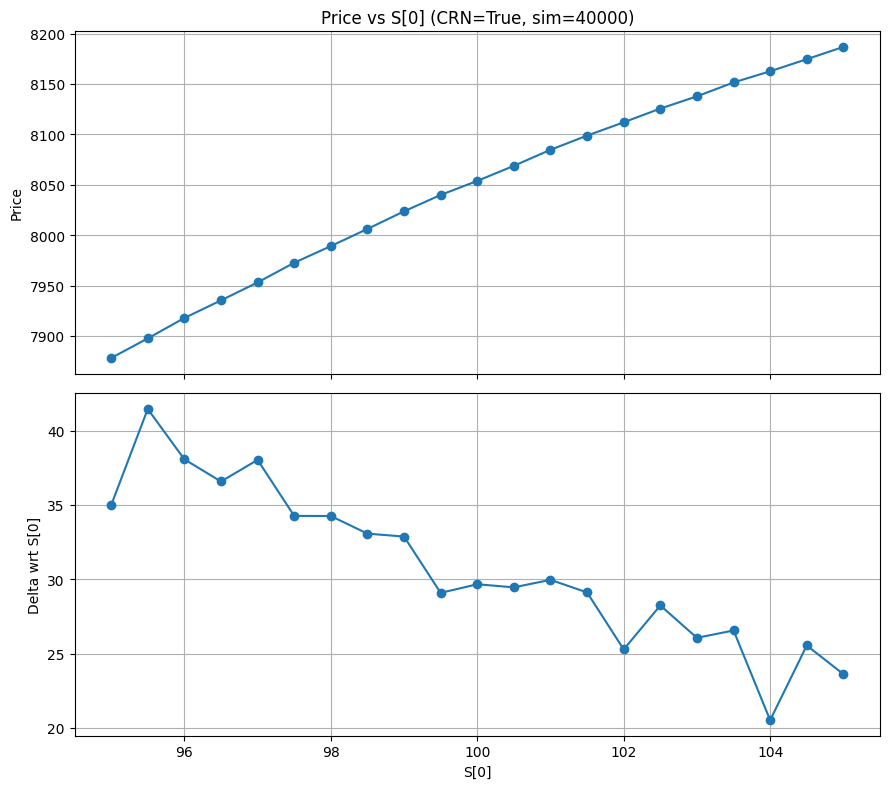

[Delta monotonicity check]
- fraction of decreasing steps: 0.650
- worst increase in Delta between adjacent grid points: 6.474217


In [26]:
out = delta_vs_S_SD3(
    pricer=SD_3star_GPU_CRN,
    S0=S0, kijun=kijun, K=K, T=T, c=c,
    r=r, q=q, sigma=sigma, Corr=Corr3,
    barrier=barrier, dummy=dummy,
    asset_idx=0,
    sim=40000,
    width=0.05,
    n_grid=21,
    bump_S_frac=0.01,
    use_crn=True
)
